# Basic Model Training with TensorFlow 2.0

## Project Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.0.0-beta1'

## Staging Data

![](cloud_storage.png)

**Pros and Cons of Preprocessing Data in Bigquery**

- (+) Efficient transformations
- (+) Easy to apply to new data within schema
- (+) Scalability
- (-) Limited Features
- (-) Transfer over Network 

In [2]:
%%bigquery flights_df --verbose

SELECT 

  -- We are binning the departure_delay to capture the data better 0, 2, 3, 6, 9, 13, 19, 28, 44, 76, 120
  CASE WHEN (departure_delay < 2) THEN 1 ELSE 0 END AS departure_delay_bin_0,
  CASE WHEN (2 <= departure_delay AND departure_delay < 3) THEN 1 ELSE 0 END AS departure_delay_bin_1,
  CASE WHEN (3 <= departure_delay AND departure_delay < 6) THEN 1 ELSE 0 END AS departure_delay_bin_2,
  CASE WHEN (6 <= departure_delay AND departure_delay < 9) THEN 1 ELSE 0 END AS departure_delay_bin_3,
  CASE WHEN (9 <= departure_delay AND departure_delay < 13) THEN 1 ELSE 0 END AS departure_delay_bin_4,
  CASE WHEN (13 <= departure_delay AND departure_delay < 19) THEN 1 ELSE 0 END AS departure_delay_bin_5,
  CASE WHEN (19 <= departure_delay AND departure_delay < 28) THEN 1 ELSE 0 END AS departure_delay_bin_6,
  CASE WHEN (28 <= departure_delay AND departure_delay < 44) THEN 1 ELSE 0 END AS departure_delay_bin_7,
  CASE WHEN (44 <= departure_delay AND departure_delay < 76) THEN 1 ELSE 0 END AS departure_delay_bin_8,
  CASE WHEN (76 <= departure_delay) THEN 1 ELSE 0 END AS departure_delay_bin_9,
  
  departure_delay, -- just for demo purposes
  
  -- We are binning the distance to capture the data better 600, 1200 km
  CASE WHEN (distance < 600) THEN 1 ELSE 0 END AS distance_bin_0,
  CASE WHEN (600 <= distance AND distance < 1200) THEN 1 ELSE 0 END AS distance_bin_1,
  CASE WHEN (1200 <= distance) THEN 1 ELSE 0 END AS distance_bin_2,
  
  -- Target column
  CASE WHEN (arrival_delay >= 15) THEN 1 ELSE 0 END as delayed
  
  FROM ( 
    
    -- Inner Query
    SELECT
      ROUND(ST_DISTANCE(ST_GEOGPOINT(departure_lon, departure_lat), ST_GEOGPOINT(arrival_lon, arrival_lat))/1000) as distance,
      departure_delay,
      arrival_delay
    FROM
      `bigquery-samples.airline_ontime_data.flights`
    WHERE date >= '2009-01-01' 
    AND date <= '2009-12-31'
    AND departure_delay > 0          
  )


Executing query with job ID: f19fb66d-d6ed-4a1f-9b8c-e3165a0b750a
Query executing: 8.99s
Query complete after 11.96s


In [3]:
flights_df.shape

(2302332, 15)

In [4]:
flights_df.sample(n = 5)

,departure_delay_bin_0,departure_delay_bin_1,departure_delay_bin_2,departure_delay_bin_3,departure_delay_bin_4,departure_delay_bin_5,departure_delay_bin_6,departure_delay_bin_7,departure_delay_bin_8,departure_delay_bin_9,departure_delay,distance_bin_0,distance_bin_1,distance_bin_2,delayed
1018911,0,0,0,0,0,1,0,0,0,0,13.0,0,1,0,0
1322916,0,0,0,0,0,0,1,0,0,0,21.0,1,0,0,1
168934,0,0,1,0,0,0,0,0,0,0,4.0,1,0,0,0
1969899,0,0,0,1,0,0,0,0,0,0,7.0,0,0,1,0
590672,0,0,0,0,0,0,0,1,0,0,33.0,1,0,0,1


## Data Preprocessing

Why are we binning?

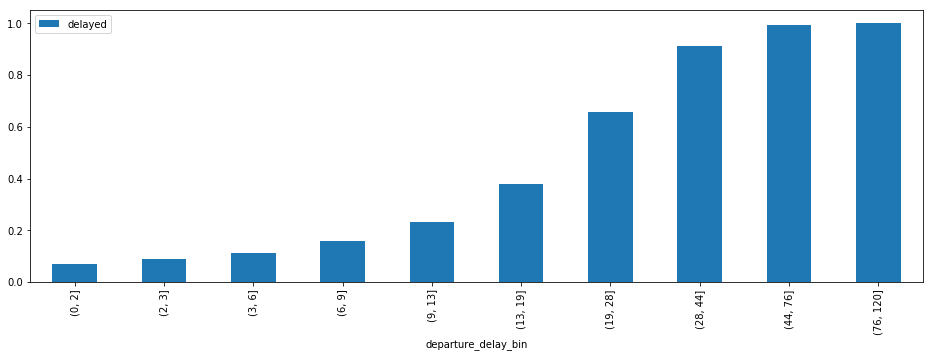

In [10]:
flights_df['departure_delay_bin'] = pd.cut(flights_df['departure_delay'], [0, 2, 3, 6, 9, 13, 19, 28, 44, 76, 120])
(flights_df
 .filter(['departure_delay_bin', 'delayed'])
 .groupby('departure_delay_bin')
 .agg('mean')
 .plot.bar(figsize = (16,5))
)

Let's drop the departure_delay numeric variable because we are not needing it.

In [11]:
flights_df = flights_df.drop(columns = ["departure_delay_bin", "departure_delay"])

In [12]:
flights_df.dtypes

departure_delay_bin_0    int64
departure_delay_bin_1    int64
departure_delay_bin_2    int64
departure_delay_bin_3    int64
departure_delay_bin_4    int64
departure_delay_bin_5    int64
departure_delay_bin_6    int64
departure_delay_bin_7    int64
departure_delay_bin_8    int64
departure_delay_bin_9    int64
distance_bin_0           int64
distance_bin_1           int64
distance_bin_2           int64
delayed                  int64
dtype: object

## Model Training using Keras API

### Training-Testing-Split

In [13]:
train_df = flights_df.sample(frac=0.85,random_state=123)
test_df = flights_df.drop(train_df.index)
print(train_df.delayed.mean())
print(test_df.delayed.mean())

train_labels = train_df.pop('delayed')
test_labels = test_df.pop('delayed')

0.450877422480125
0.45111625886781526


In [14]:
# Initialize a Sequential model using TF.Keras API:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape = [len(train_df.keys())])])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
             )

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


The model itself is still very simple (logistic regression). The complexity comes through feature engineering and dummy variables. For the regression though this isn't a a problem because many of the computations will be 0 because it is essentially a weighted sum.

In [16]:
history = model.fit(train_df, train_labels, 
                    epochs = 3,
                    callbacks = [tf.keras.callbacks.TensorBoard("logs/logistic-regression")])

W0903 20:10:07.095013 140719213967104 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1956982 samples
Epoch 1/3
1956982/1956982 [==============================] - 171s 87us/sample - loss: 0.3541 - accuracy: 0.8531
Epoch 2/3
1956982/1956982 [==============================] - 156s 80us/sample - loss: 0.3447 - accuracy: 0.8566
Epoch 3/3
1956982/1956982 [==============================] - 148s 76us/sample - loss: 0.3447 - accuracy: 0.8566


## Testing Model Predictions

### Performance evaluation of logistic regression on test data

In [17]:
test_predictions = model.predict(test_df).flatten()

test_predictions[:10]

array([0.88899755, 0.12889078, 0.3172538 , 0.3172538 , 0.05599916,
       0.88899755, 0.9928516 , 0.08760107, 0.05599916, 0.9999999 ],
      dtype=float32)

In [18]:
predicted_labels = (test_predictions > 0.5).astype(int)

predicted_labels[:10]

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [19]:
results_df = pd.DataFrame({'Predicted': predicted_labels, 'Actual': test_labels})
results_df.head(10)

,Actual,Predicted
2,1,1
4,0,0
8,0,0
16,0,0
29,0,0
33,1,1
36,1,1
41,0,0
60,0,0
78,1,1


### Evaluate on test data

In [21]:
results = model.evaluate(test_df, test_labels)
print('test loss, test acc:', results)

345350/345350 [==============================] - 7s 20us/sample - loss: 0.3451 - accuracy: 0.8563
test loss, test acc: [0.3450876065613617, 0.85631096]


### Create the confusion matrix

In [22]:
confusion_matrix = pd.crosstab(results_df['Actual'], results_df['Predicted'], margins = True)

In [23]:
confusion_matrix

Predicted,0,1,All
Actual,,,
0,172768,16789,189557
1,32834,122959,155793
All,205602,139748,345350


**Accuracy**: How many observations did we label correctly out of all the observations? 

**Precision**: How many of those that we labeled as positive were actually positive?

**Recall**: Of all the positive class labels, how many of those did we correctly predict?

**F1 Score**: F1-Score is a combination of both recall and precision. The F1 Score is low if one measure is improved at the expense of the other. For example, if Precision is 1 and Recall is 0, the F1 score is 0.

In [24]:
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
TN = confusion_matrix.loc[0, 0]
FN = confusion_matrix.loc[1, 0]

In [25]:
accuracy = (TP+TN)/(TP+FP+FN+TN)
accuracy

0.8563109888518894

In [26]:
precision = TP/(TP+FP)
precision

0.8798623236110713

In [27]:
recall = TP/(TP+FN)
recall

0.7892459866617884

In [28]:
f1 = 2*(recall * precision) / (recall + precision)
f1

0.8320943625419146

## Exporting the Model for Production

In [25]:
tf.saved_model.save(model, "model/1/")

In [30]:
%%bash
gsutil cp -r model/1/ gs://tensorflow-ml-course-blob/models

Copying file://model/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://model/1/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://model/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
-
Operation completed over 3 objects/43.1 KiB.                                     


## Deploy to AI Platform

In [87]:
%%bash
gcloud ai-platform models create flights_logistic_regression

Created ml engine model [projects/tensorflow-ml-course/models/flights_logistic_regression].


In [88]:
%%bash

MODEL_DIR="gs://tensorflow-ml-course-blob/models/1"
VERSION_NAME="v1"
MODEL_NAME="flights_logistic_regression"
FRAMEWORK="tensorflow"

gcloud ai-platform versions create $VERSION_NAME \
  --model $MODEL_NAME \
  --origin $MODEL_DIR \
  --runtime-version=1.14 \
  --framework $FRAMEWORK \
  --python-version=3.5

Creating version (this might take a few minutes)......
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
